In [1]:
import os
import os.path as op
import json
import cv2
import base64
import numpy as np
from tqdm import tqdm

import numpy as np
import matplotlib.pyplot as plt

from PIL import Image, ImageDraw

from maskrcnn_benchmark.structures.tsv_file_ops import tsv_reader, tsv_writer
from maskrcnn_benchmark.structures.tsv_file_ops import generate_linelist_file
from maskrcnn_benchmark.structures.tsv_file_ops import generate_hw_file
from maskrcnn_benchmark.structures.tsv_file import TSVFile
from maskrcnn_benchmark.data.datasets.utils.image_ops import img_from_base64

In [2]:
#orig_root = '../../../datasets/textcaps_orig'
orig_root = '../../../../datasets/textcaps_orig'

# orig_img_train_val_dir = op.join(orig_root, 'train_val_images')  # Contains train & val images
# orig_img_test_dir = op.join(orig_root, 'test_images')

orig_cap_filenames = {split: f'TextCaps_0.1_{split}.json' for split in ['train', 'val', 'test']}

# exp_root = '../../../datasets/textcaps_nn'
exp_root = '../../../../datasets/textcaps_nn'

In [3]:
# Load TextCaps captions

caps = {'train': [], 'val': [], 'test': []}

for split in caps.keys():
    cap_filename = op.join(orig_root, orig_cap_filenames[split])
    with open(cap_filename) as fp:
        captions_json = json.load(fp)
    caps[split] = captions_json['data']

# caps['train'][0]

In [4]:
img_list = {split_name: set([item['image_id'] + '.jpg' for item in caps[split_name]]) for split_name in caps.keys()}
for split in img_list:
    print(len(img_list[split]))

21953
3166
3289


In [5]:
# Load TextCaps EasyOCR OCR tags

with open(op.join(orig_root, 'ocr_tags.json')) as fp:
    ocr_json = json.load(fp)

In [6]:
# split = 'val'
# images_wh = {el['image_id']: [el['image_width'], el['image_height']] for el in caps[split]}
# images_wh

In [7]:
split_img_ids = {
    'train': set([item['image_id'] for item in caps['train']]),
    'val': set([item['image_id'] for item in caps['val']]),
}

# GENERATE JSON 
for split in ['train', 'val']:
    images_wh = {el['image_id']: [el['image_width'], el['image_height']] for el in caps[split]}
    ocr_filename = op.join(exp_root, f'{split}_ocr_easyocr.json')
    ocr_split = [el for el in ocr_json if el['image_id'] in split_img_ids[split]]
    for item in tqdm(ocr_split):
        for block in item['data']:
            b = block[0]
            # print(b)
            w, h = images_wh[item['image_id']]
            # print(w, h)
            x1, y1, x2, y2 = b[0]/w, b[1]/h, b[2]/w, b[3]/h
            assert x1 <= 1.0 
            assert y1 <= 1.0
            #assert x2 <= 1.0
            #if y2 > 1:
            #    print(b, h)
            #    print(y2)
            #assert y2 <= 1.0
            block[0] = [x1, y1, x2, y2]
        # print(item)
    # a = ocr_split[1]
    # w, h = images_wh[a['image_id']]
    # print(a)
    # print(w, h)
    with open(ocr_filename, 'w') as fp:
        json.dump(ocr_split, fp)

100%|██████████| 3166/3166 [00:00<00:00, 199210.41it/s]


In [8]:
# Load TextCaps Rosetta OCR tags

ocr_rosetta_json = {}
for split in ['train', 'val']:
    with open(op.join(orig_root, f'TextVQA_Rosetta_OCR_v0.2_{split}.json')) as fp:
        ocr_rosetta_json[split] = json.load(fp)

In [9]:
def draw_box(draw, bbox):
    #b = [[p[0]*k, p[1]*k] for p in bbox]
    draw.line(b[0] + b[1], fill=255)
    draw.line(b[1] + b[2], fill=255)
    draw.line(b[2] + b[3], fill=255)
    draw.line(b[3] + b[0], fill=255)    

In [10]:
sample_img = ocr_rosetta_json['val']['data'][2]
print(
    sample_img['image_id'], '\n',
    sample_img['ocr_tokens'][0], '\n',
    sample_img['ocr_info'][0]['word'], '\n',
    sample_img['ocr_info'][0]['bounding_box'], '\n',
    # sample_img['ocr_tokens'][1], '\n',
)

1f3559f9f45a1f1d 
 BISE 
 BISE 
 {'width': 0.07045308500528336, 'height': 0.027657225728034973, 'rotation': 0, 'roll': 0, 'pitch': 0, 'yaw': 0.7450203895568848, 'top_left_x': 0.10000614076852798, 'top_left_y': 0.030976925045251846} 



In [25]:
results_filename = 'pred.textcaps.val.beam1.max20.odlabels_coco_format.json'

with open(op.join(orig_root, results_filename)) as fp:
    res_json = json.load(fp)

res_dict = {s['image_id']: s['caption'] for s in res_json}
# res_dict['105bb5dae2923dea']

Detected OCR text: LU | 0185077 | LUX | 79.99.9 | 
GENERATED CAP: a sign that has the numbers 797 on it


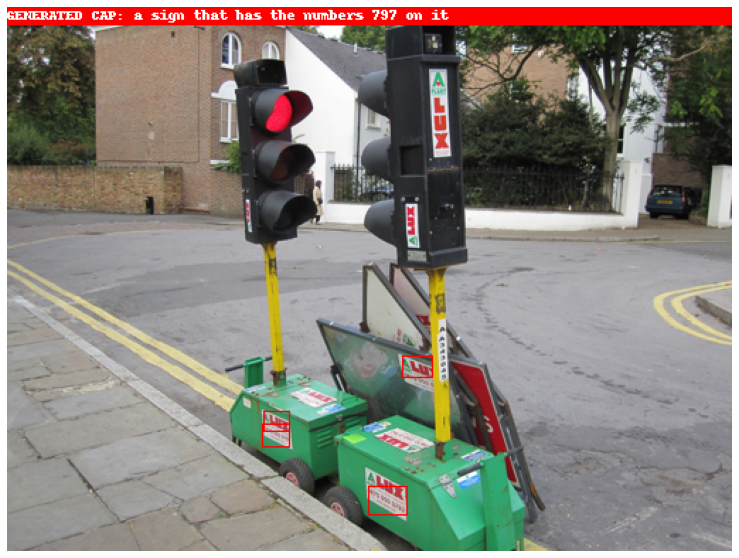

In [126]:
sample_img = ocr_rosetta_json['val']['data'][500]  # 4 18 19 22 40 42 45 55
# print(sample_img['image_id'])

im_filename = os.path.join(orig_root, 'train_images', sample_img['image_id'] + '.jpg')
im = Image.open(im_filename)
im = im.resize((im.width//2, im.height//2))

plt.figure(figsize=(16,10))
draw = ImageDraw.Draw(im)

print('Detected OCR text: ', end='')
for block in sample_img['ocr_info']:
    bbox = block['bounding_box']
    text = block['word']
    print(text, end=' | ')
    x1, y1 = bbox['top_left_x'], bbox['top_left_y']
    w, h = bbox['width'], bbox['height']
    x2 = x1 + w
    y2 = y1 + h
    x1, x2 = x1 * im.width, x2 * im.width
    y1, y2 = y1 * im.height, y2 * im.height
    w, h = w * im.width, h * im.height
    draw.rectangle((x1, y1, x2, y2), outline=255)

text_cap = f"GENERATED CAP: {res_dict[sample_img['image_id']]}"
print('\n' + text_cap)

max_str_len = im.width // 6  # max string length in letters
strings_num = len(text_cap) // max_str_len + 1

b_text = [0, 0, im.width, 12 * strings_num]
draw.rectangle(b_text, fill=255)

text_cap_chunks = [text_cap[seek: seek + max_str_len] for seek in range(0, len(text_cap), max_str_len)]
for i, chunk in enumerate(text_cap_chunks):
    draw.text((0, i * 12), chunk, stroke_width=40, stroke_fill=255)

plt.axis('off')

plt.imshow(im);
# plt.savefig(sample_img['image_id'] + '.png', bbox_inches='tight')

In [120]:
ocr_rosetta_splits = {}
for split in ['train', 'val']:
    split_list = []
    for img in ocr_rosetta_json[split]['data']:
        split_list.append({
            'image_id': img['image_id'],
            'data': [[
                [
                    block['bounding_box']['top_left_x'],
                    block['bounding_box']['top_left_y'], 
                    block['bounding_box']['top_left_x'] + block['bounding_box']['width'],
                    block['bounding_box']['top_left_y'] + block['bounding_box']['height'], 
                    block['bounding_box']['width'], 
                    block['bounding_box']['height'],
                ], 
                block['word'], 
                1.0] for block in img['ocr_info']]
        })
    ocr_rosetta_splits[split] = split_list
# ocr_rosetta_splits['train'][1]

In [121]:
split_img_ids = {
    'train': set([item['image_id'] for item in caps['train']]),
    'val': set([item['image_id'] for item in caps['val']]),
}

# GENERATE JSON 
for split in ['train', 'val']:
    ocr_filename = op.join(exp_root, f'{split}_ocr_rosetta.json')
    ocr_split = [el for el in ocr_rosetta_splits[split] if el['image_id'] in split_img_ids[split]]
    with open(ocr_filename, 'w') as fp:
        json.dump(ocr_split, fp)

In [13]:
for split in caps.keys():
    rows = []
    rows_label = []
    rows_hw = []

    # i = 2
    for img_p in tqdm(img_list[split]):
        img_key = img_p.split('.')[0]
        img_path = op.join(orig_root, f"{'test' if split=='test' else 'train_val_images/train'}_images", img_p)
        img = cv2.imread(img_path)
        img_encoded_str = base64.b64encode(cv2.imencode('.jpg', img)[1])
        row = [img_key, img_encoded_str]
        # print(row[1][800:900] , flush=True)
        rows.append(row)

        height = img.shape[0]
        width = img.shape[1]
        row_hw = [img_key, json.dumps([{'height': height, 'width': width}])]
        rows_hw.append(row_hw)
        # i -= 1
        # if i == 0:
        #     break
        
    exp_encoded_img_file = op.join(exp_root, f'{split}.img.tsv')
    exp_hw_file = op.join(exp_root, f'{split}.hw.tsv')
    print(exp_encoded_img_file, flush=True)
    tsv_writer(rows, exp_encoded_img_file)
    # tsv_writer(rows_label, label_file)
    tsv_writer(rows_hw, exp_hw_file)

100%|██████████| 21953/21953 [06:04<00:00, 60.22it/s]

../../../datasets/textcaps_nn/train.img.tsv



100%|██████████| 3166/3166 [00:53<00:00, 59.17it/s]

../../../datasets/textcaps_nn/val.img.tsv



100%|██████████| 3289/3289 [00:55<00:00, 58.80it/s]

../../../datasets/textcaps_nn/test.img.tsv


In [14]:
# caps['val'][0]

In [65]:
def generate_cap_json(split: str):
    captions = []
    cap_idx = 0
    for sample in caps[split]:
        image_id = sample['image_id']
        caption_str = sample['caption_str']
        captions.append(
            {
                'image_id': image_id,
                'id': cap_idx,
                'caption': caption_str,
            }
        )
        cap_idx +=1
        print(sample)
        break
    captions = sorted(captions, key=lambda k: k['image_id'])
#     print(captions[:10])
    return captions

generate_cap_json('val');

{'image_id': 'caef3d1e97c2cf15', 'image_classes': ['Person', 'Box', 'Table', 'Clothing', 'Book'], 'flickr_original_url': 'https://farm6.staticflickr.com/8620/16450641419_1348e01994_o.jpg', 'flickr_300k_url': 'https://c5.staticflickr.com/9/8620/16450641419_daf4ae8ee4_z.jpg', 'image_width': 1024, 'image_height': 1024, 'set_name': 'val', 'image_name': 'caef3d1e97c2cf15', 'image_path': 'train/caef3d1e97c2cf15.jpg', 'caption_id': 200000000, 'caption_str': 'A book about CEOs is sitting on top of a box.', 'caption_tokens': ['<s>', 'a', 'book', 'about', 'ceos', 'is', 'sitting', 'on', 'top', 'of', 'a', 'box', '</s>'], 'reference_strs': ['A book about CEOs is sitting on top of a box.', 'a book called CEO (Customer Engagement Officer) by Mark Hillary.', 'A book titled CEO (Customer Engagement Officer) on top of a cardboard box.', 'A book by Mark Hillary titled CEO sits on top of a box', "a book labeled 'CEO(cusotmer engagement officer) by mark hillary"], 'reference_tokens': [['<s>', 'a', 'book', 

In [59]:
# GENERATE JSON 

for split in ['train', 'val']:
    cap_filename = op.join(exp_root, f'{split}_caption.json')
    with open(cap_filename, 'w') as fp:
        json.dump(generate_cap_json(split), fp)

[{'image_id': '0000599864fd15b3', 'id': 10210, 'caption': 'Turqouise bus with the numbers "29267222" right behind a group of people taking a picture.'}, {'image_id': '0000599864fd15b3', 'id': 68612, 'caption': 'Five people pose for a photo as the number 5 bus passes in the background.'}, {'image_id': '0000599864fd15b3', 'id': 68743, 'caption': 'Five people pose in front of a bus that advertises for a Hong Kong company with the phone number 2926 7222.'}, {'image_id': '0000599864fd15b3', 'id': 104407, 'caption': 'A group of people are posing for a picture in front of a bus with the number 5 on it.'}, {'image_id': '0000599864fd15b3', 'id': 109362, 'caption': 'Double decker bus number 5 is a bright teal color.'}, {'image_id': '0000e8b36676338b', 'id': 176, 'caption': 'Oddly shaped bus that is apparently for private use only.'}, {'image_id': '0000e8b36676338b', 'id': 70087, 'caption': 'black and white bus with felix private above windshield and license plate of dbu 889'}, {'image_id': '0000

In [15]:
# COCO FORMAT JSON 

for split in ['val']:  #, 'test']:
    cap_filename = op.join(exp_root, f'{split}_caption_coco_format.json')
    json_annotations = generate_cap_json(split)
    json_images = [{'id': ann['image_id'], 'image_name': ann['image_id']} for ann in json_annotations]
    json_all = {
        'annotations': json_annotations,
        'images': json_images,
        'type': 'captions',
        'info': 'dummy',
        'licenses': 'dummy',
    }
    
    with open(cap_filename, 'w') as fp:
        json.dump(json_all, fp)